1. 뉴욕시의 Taxi 데이터를 활용한 예측 모델 
- 데이터셋: 캐글의 NYC_taxi.csv
    * 조건: 뉴욕시 내
- 거리에 따른 요금 예측 => 회귀

[1] 데이터 로딩

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 데이터 로딩
# nrows=로딩 데이터 수 설정
# parse_dates=로딩 데이터 타입 변환
FILE = './train.csv'
df = pd.read_csv(FILE, nrows=50000, parse_dates=['pickup_datetime'])

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In [5]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

[2] 결측치 및 이상치 체크

In [6]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [7]:
desDf = df.describe()
desDf

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [8]:
# 요금, 승차, 하차 min, max
desDf.loc[['min','max'],'fare_amount':'dropoff_latitude']

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
min,-5.0,-75.423848,-74.006893,-84.654241,-74.006377
max,200.0,40.783472,401.083332,40.851027,43.415190


In [9]:
df = df[(df['pickup_latitude']>=40.49)&(df['pickup_latitude']<=40.92)]
df = df[(df['dropoff_latitude']>=40.49)&(df['dropoff_latitude']<=40.92)]

df = df[(df['pickup_longitude']<=-73.68)&(df['pickup_longitude']>=-74.27)]
df = df[(df['dropoff_longitude']<=-73.68)&(df['dropoff_longitude']>-74.27)]

- 특성 새롭게 생성 => 거리 Feature
- 공식: (x2-x1)^2 + (y2-y1)^2의 루트

In [10]:
df['distance'] = ((df['dropoff_longitude']-df['pickup_longitude'])**2 + (df['dropoff_latitude']-df['pickup_latitude'])**2)**0.5

In [11]:
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,0.019470
...,...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1,0.045782
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1,0.008049
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1,0.020574
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2,0.007686


In [12]:
df = df[df['fare_amount']>0]
df = df[df['distance']!=0]
df = df[df['passenger_count']!=0]

In [13]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48189.000000,48189.000000,48189.000000,48189.000000,48189.000000,48189.000000,4.818900e+04
mean,11.326300,-73.975695,40.750922,-73.974490,40.751423,1.676275,3.439444e-02
std,9.351288,0.034002,0.026782,0.033865,0.030592,1.290661,3.823754e-02
min,0.010000,-74.248263,40.522263,-74.241953,40.529306,1.000000,1.000000e-06
25%,6.000000,-73.992330,40.736538,-73.991342,40.735939,1.000000,1.314290e-02
50%,8.500000,-73.982149,40.753452,-73.980528,40.754136,1.000000,2.208316e-02
75%,12.500000,-73.968558,40.767755,-73.965585,40.768473,2.000000,3.931006e-02
max,165.000000,-73.688170,40.918290,-73.699185,40.911983,6.000000,3.989352e-01


[3] 데이터 시각화

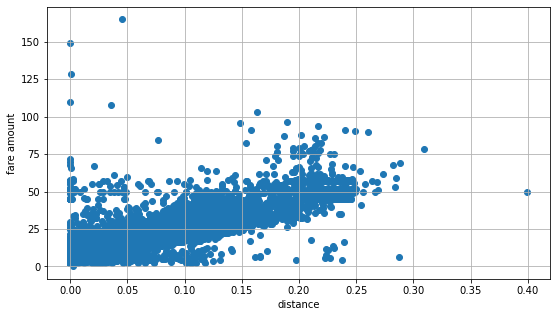

In [14]:
plt.figure(figsize=(9, 5))
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel('distance')
plt.ylabel('fare amount')
plt.grid(True)
plt.show()

1. 선형회귀

[4] 학습 데이터 준비

In [15]:
# 학습용, 테스트용 데이터 분리
from sklearn.model_selection import train_test_split

distance = np.array(list(df['distance']))
fare_amount = np.array(list(df['fare_amount']))

# 훈련 세트와 테스트 세트로 나눔
train_X, test_X, train_y, test_y = train_test_split(
                                                distance, fare_amount, random_state=42)

# 훈련 세트와 테스트 세트를 2차원 배열로 변경
train_X = train_X.reshape(-1, 1)
test_X = test_X.reshape(-1, 1)

[5] 모델 생성 & 학습

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_X, train_y)

print('coef_: {}, intercept_: {}'.format(model.coef_, model.intercept_))

coef_: [217.08158591], intercept_: 3.8389031337707946


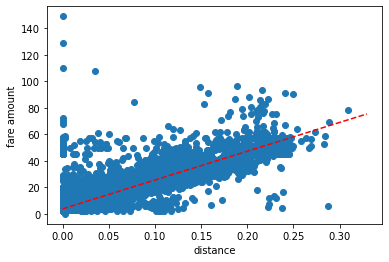

In [17]:
plt.scatter(train_X, train_y)
plt.plot([1.000000e-06, 0.3295233], [1.000000e-06*model.coef_ + model.intercept_, 0.3295233*model.coef_ + model.intercept_], color='red', linestyle='--')
plt.xlabel('distance')
plt.ylabel('fare amount')
plt.show()

[6] 모델 평가

In [18]:
print('train data score: {}'.format(model.score(train_X, train_y)))
print('test data score: {}'.format(model.score(test_X, test_y)))

train data score: 0.790992032613516
test data score: 0.7767102778114074


2. 다항회귀

[1] 학습 데이터 준비

In [19]:
train_poly = np.column_stack((train_X**2, train_X))
test_poly = np.column_stack((test_X**2, test_X))

print(train_poly[:5])
print(train_poly.shape, test_poly.shape)

[[6.71264633e-04 2.59087752e-02]
 [1.50534337e-03 3.87987547e-02]
 [3.57835829e-04 1.89165491e-02]
 [9.75400000e-05 9.87623410e-03]
 [4.83861759e-03 6.95601724e-02]]
(36141, 2) (12048, 2)


[2] 모델 생성 & 학습

In [20]:
lr = LinearRegression()
lr.fit(train_poly, train_y)
print('coef_: {}, intercept_: {}'.format(lr.coef_, lr.intercept_))

coef_: [-44.57023052 225.31670935], intercept_: 3.673664492008249


왜 선형..?

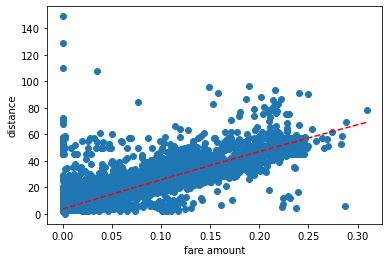

In [28]:
point = np.arange(9.99999997e-07, 0.30944998, 0.0000001)
plt.scatter(train_X, train_y)
plt.plot(point, (-44.57023052)*point**2 + 225.31670935*point + 3.673664492008249, color = 'red', linestyle='--')
plt.xlabel('fare amount')
plt.ylabel('distance')
plt.show()

[3] 모델 평가

In [27]:
print('train data score: {}'.format(lr.score(train_poly, train_y)))
print('test data score: {}'.format(lr.score(test_poly, test_y)))

train data score: 0.7911742043427711
test data score: 0.7773254907761918
